# 1. 分析过程
#### 识别客户价值应用最广泛的模型是通过3个指标（最近消费时间间隔（Recency）、消费频率（Frequency）和消费金额（Money））来进行客户细分，识别出高价值客户，简称RFM模型。

RFM模型中，消费金额表示一段时间内，客户购买企业产品金额的总和。由于航空票价受到运输距离、舱位等级等多种因素影响，同样消费金额的不同旅客对航空公司的价值是不同的。例如，一位购买长航线、低等舱位票的旅客与一位购买短航线、高等级舱位票的旅客相比，后者对于航空公司的价值可能更高。因此，这个指标并不适合航空公司客户价值分析。我们选择客户在一定时间内累积的飞行里程M和客户在一定时间内乘坐舱位所对应的折扣系数的平均值C两个指标代替消费金额。此外，还考虑航空公司会员入会时间的长短在一定程度上影响客户价值，所以在模型中增加客户关系长度L，作为区分客户的另一指标。


综上所述，航空公司识别客户价值模型（LRFMC）指标如下：


#### 客户关系长度L：会员入会时间距观测窗口结束的月份

#### 消费时间间隔R：客户最近一次乘坐公司飞机距观测窗口结束的月数

#### 消费频率F：客户在观测窗口内乘坐公司飞机的次数

#### 飞行里程M：客户在观测窗口内飞行里程

#### 折扣系数的平均值C：客户在观测窗口内乘坐舱位所对应的折扣系数的平均值


 传统的RFM模型采用属性分箱的方法，如下图所示（依据属性的平均值进行划分），虽然也能识别出最有价值客户，但是如果LRFMC模型使用同样的方法，则细分的属性太多，提高了后续根据客户类别的营销成本。故本次分析使用聚类方法，通过对航空公司客户价值的五个指标进行Kmeans聚类分析，识别出最有价值客户。


### 航空公司客户价值信息挖掘主要包話以下步骤：


（1）从航空公司的数据源中进行选择性抽取与新增数据抽取分别形成历史数据和增量数据；

（2）对步骤1）中形成的两个数据集进行数据探索分析和预处理，包括数据缺失值和异常值分析，数据属性的规约、清洗和变换；

（3）利用步骤2）中的处理的数据进行建模，基于旅客价值的LRFMC模型进行客户分类，对各个客户群进行特征分析，识别出最有价值的客户；

（4）针对模型结果得到不同价值的客户，采用不同的营销手段，提供定制化的服务。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("air_data.csv")

In [3]:
df.shape

(62988, 44)

In [4]:
df.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,ADD_Point_SUM,Eli_Add_Point_Sum,L1Y_ELi_Add_Points,Points_Sum,L1Y_Points_Sum,Ration_L1Y_Flight_Count,Ration_P1Y_Flight_Count,Ration_P1Y_BPS,Ration_L1Y_BPS,Point_NotFlight
0,54993,2006/11/02,2008/12/24,男,6,.,北京,CN,31.0,2014/03/31,...,39992,114452,111100,619760,370211,0.509524,0.490476,0.487221,0.512777,50
1,28065,2007/02/19,2007/08/03,男,6,NaN,北京,CN,42.0,2014/03/31,...,12000,53288,53288,415768,238410,0.514286,0.485714,0.489289,0.510708,33
2,55106,2007/02/01,2007/08/30,男,6,.,北京,CN,40.0,2014/03/31,...,15491,55202,51711,406361,233798,0.518519,0.481481,0.481467,0.518530,26
3,21189,2008/08/22,2008/08/23,男,5,Los Angeles,CA,US,64.0,2014/03/31,...,0,34890,34890,372204,186100,0.434783,0.565217,0.551722,0.448275,12
4,39546,2009/04/10,2009/04/15,男,6,贵阳,贵州,CN,48.0,2014/03/31,...,22704,64969,64969,338813,210365,0.532895,0.467105,0.469054,0.530943,39


In [5]:
df.columns

Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'EP_SUM_YR_1', 'EP_SUM_YR_2', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'WEIGHTED_SEG_KM', 'LAST_FLIGHT_DATE',
       'AVG_FLIGHT_COUNT', 'AVG_BP_SUM', 'BEGIN_TO_FIRST', 'LAST_TO_END',
       'AVG_INTERVAL', 'MAX_INTERVAL', 'ADD_POINTS_SUM_YR_1',
       'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount',
       'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BP_SUM', 'L1Y_BP_SUM',
       'EP_SUM', 'ADD_Point_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points',
       'Points_Sum', 'L1Y_Points_Sum', 'Ration_L1Y_Flight_Count',
       'Ration_P1Y_Flight_Count', 'Ration_P1Y_BPS', 'Ration_L1Y_BPS',
       'Point_NotFlight'],
      dtype='object')

# 2. 数据探索分析

针对本项目的数据，主要进行缺失值分析和异常值分析。比如票价为空值，票价最小值为0、折扣率最小值为、总飞行里程数大于零的记录。
拿到原始数据后，可以使用Python代码实现对数据的初步分析，主要使用pandas库中的describe()函数，代码如下：

In [6]:
# 包括对数据的基本描述，percentiles参数是指定计算多少的分位数表（如1/4分位数、中位数等）；T是转置，转置后更方便查
explore = df.describe(percentiles=[],include="all").T


#describe()函数自动计算非空值数，需要手动计算空值数
explore["null"] = len(df) - explore["count"]
 
explore = explore[["null","max","min"]]
explore.columns = [u"空数值",u"最大值",u"最小值"] #对结果统计的表头重命名

# 这里只选取部分探索结果。
# describe()函数自动计算的字段有count（非空值数）、unique（唯一值数）、top（频数最高者）、
# freq（最高频数）、mean（平均值）、std（方差）、min（最小值）、50%（中位数）、max（最大值）
# print(explore)
 
explore.to_excel("./explore.xls") ##导出结果

# 3. 数据预处理

### 针对上述问题的数据预处理包括数据清洗、属性规约和数据变换。

## 3.1数据清洗
由上述分析可知，原始数据中存在着票价为空值，票价最小值为0、折扣率最小值为0而总飞行里程数大于零的等异常记录。考虑原始数据样本量较大，而这类数据的数量又很小，因此可以选择舍弃处理。

1.舍弃票价为空的记录；

2.舍弃票价为零、平均折扣率不为零，总飞行公里大于零的数据。

In [7]:
#票价非空值保留
df = df[df['SUM_YR_1'].notnull() * df['SUM_YR_2'].notnull()]

#只保留非空票价，或者平均值扣率与总飞行公里数同时为0的记录
index1 = df['SUM_YR_1'] !=0
index2 = df['SUM_YR_2'] !=0
index3 = (df['SEG_KM_SUM'] == 0) & (df['avg_discount'] ==0)

df = df[index1|index2|index3]

In [8]:
df.shape

(62044, 44)

In [9]:
62044/62988

0.985013018352702

处理后的数据有 62044 条，占原数据的 98.501%，因此不会对分析结果产生较大的影响

## 3.2 属性归约

原始数据中有众多属性，需要选取与本次模型相关的属性，最终选取的7个相关属性分别为：
+ 会员卡号（MEMBER_NO）
+ 入会时间（FFP_DATE）
+ 观测窗口的结束时间（LOAD_TIME）
+ 飞行次数（FLIGHT_COUNT）
+ 平均折扣率（AVG_DISCOUNT）
+ 观测窗口总飞行里程数（SEG_KM_SUM）
+ 最后一次乘机时间至观察窗口末端时长（LAST_TO_END）

删除与模型不相关、弱相关或冗余的属性，比如，性别、工作地城市、工作地所在省份等

In [10]:
data = df[["MEMBER_NO","FFP_DATE","LOAD_TIME","FLIGHT_COUNT","avg_discount","SEG_KM_SUM","LAST_TO_END"]]

In [11]:
data.head()

,MEMBER_NO,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,avg_discount,SEG_KM_SUM,LAST_TO_END
0,54993,2006/11/02,2014/03/31,210,0.961639,580717,1
1,28065,2007/02/19,2014/03/31,140,1.252314,293678,7
2,55106,2007/02/01,2014/03/31,135,1.254676,283712,11
3,21189,2008/08/22,2014/03/31,23,1.090870,281336,97
4,39546,2009/04/10,2014/03/31,152,0.970658,309928,5


In [12]:
data.reset_index(drop=True,inplace=True)
data.head().append(data.tail())

,MEMBER_NO,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,avg_discount,SEG_KM_SUM,LAST_TO_END
0,54993,2006/11/02,2014/03/31,210,0.961639,580717,1
1,28065,2007/02/19,2014/03/31,140,1.252314,293678,7
2,55106,2007/02/01,2014/03/31,135,1.254676,283712,11
3,21189,2008/08/22,2014/03/31,23,1.090870,281336,97
4,39546,2009/04/10,2014/03/31,152,0.970658,309928,5
62039,11163,2005/05/08,2014/03/31,2,0.710000,368,89
62040,30765,2008/11/16,2014/03/31,2,0.670000,368,121
62041,10380,2010/07/08,2014/03/31,2,0.225000,1062,39
62042,16372,2012/12/20,2014/03/31,2,0.250000,904,464
62043,22761,2011/04/14,2014/03/31,2,0.280000,760,282


## 3.3 数据变换并计算LRFMC数据

数据变换，即将数据变换为“适当的”格式，以适应挖掘任务以及算法的需求。本项目主要的数据变换方式为属性构造和数据标准化。

### LRFMC 模型指标含义

+ L：Long，会员入会时间距观测窗口结束的时间（月份），入会时间。 
+ R：Recency 客户最近一次乘坐公司飞机距离观测窗口结束的时间（月份）。 
+ F：Frequency 客户在观测窗口内乘坐公司飞机的次数。 
+ M：Milepost，客户在观测窗口内累计的飞行里程碑。 
+ C：Count，客户在观测窗口内乘坐仓位所对应的折扣系数的平均值。

### 3.3.1 属性构造

由于数据中并没有直接给出LRFMC5个指标，需要通过属性构造来提取这5个指标。具体的计算方式如下：

（1）L=LOAD_TIME-FFP_DATE

（2）R=LAST_TO_END

（3）F=FLIGHT_COUNT

（4）M=SEG_KM_SUM

（5）C= AVG_DISCOUNT

In [13]:
# 转化为时间格式
data['FFP_DATE'] = pd.to_datetime(data['FFP_DATE'])
data['LOAD_TIME'] = pd.to_datetime(data['LOAD_TIME'])
print(data.dtypes)
data.head()

MEMBER_NO                int64
FFP_DATE        datetime64[ns]
LOAD_TIME       datetime64[ns]
FLIGHT_COUNT             int64
avg_discount           float64
SEG_KM_SUM               int64
LAST_TO_END              int64
dtype: object


,MEMBER_NO,FFP_DATE,LOAD_TIME,FLIGHT_COUNT,avg_discount,SEG_KM_SUM,LAST_TO_END
0,54993,2006-11-02,2014-03-31,210,0.961639,580717,1
1,28065,2007-02-19,2014-03-31,140,1.252314,293678,7
2,55106,2007-02-01,2014-03-31,135,1.254676,283712,11
3,21189,2008-08-22,2014-03-31,23,1.090870,281336,97
4,39546,2009-04-10,2014-03-31,152,0.970658,309928,5


In [14]:
# 创建一个新的数据框
data_LRFMC = pd.DataFrame()
# data_LRFMC['MEMBER_NO'] = data['MEMBER_NO']
data_LRFMC['L'] = [x.days for  x in (data['LOAD_TIME']-data['FFP_DATE'])/30]
data_LRFMC['R'] = data['LAST_TO_END']
data_LRFMC['F'] = data['FLIGHT_COUNT']
data_LRFMC['M'] = data['SEG_KM_SUM']
data_LRFMC['C'] = data['avg_discount']

data_LRFMC.shape

(62044, 5)

In [15]:
data_LRFMC.head()

,L,R,F,M,C
0,90,1,210,580717,0.961639
1,86,7,140,293678,1.252314
2,87,11,135,283712,1.254676
3,68,97,23,281336,1.090870
4,60,5,152,309928,0.970658


### 3.3.2 数据标准化

得到LRFMC5个指标后，对这五个指标进行分析，发现五个指标取值范围数据差异较大，为了消除数量级数据带来的影响，需要对数据进行标准化处理，本次使用标准差标准化处理，代码如下所示：

In [16]:
# 数据探索性分析
data_LRFMC.describe().T

,count,mean,std,min,25%,50%,75%,max
L,62044.0,49.139288,28.264374,12.000000,24.000000,42.000000,72.000000,114.0
R,62044.0,172.532703,181.526164,1.000000,29.000000,105.000000,260.000000,731.0
F,62044.0,11.971359,14.110619,2.000000,3.000000,7.000000,15.000000,213.0
M,62044.0,17321.694749,21052.728111,368.000000,4874.000000,10200.000000,21522.500000,580717.0
C,62044.0,0.722180,0.184833,0.136017,0.613085,0.712162,0.809293,1.5


In [17]:
# 最大最小标准化数据
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()  # 实例化一个最小最大化方法
data_mms = min_max_scaler.fit_transform(data_LRFMC)  # 对数据进行标准化
data_mms

array([[7.64705882e-01, 0.00000000e+00, 9.85781991e-01, 1.00000000e+00,
        6.05302416e-01],
       [7.25490196e-01, 8.21917808e-03, 6.54028436e-01, 5.05402783e-01,
        8.18410138e-01],
       [7.35294118e-01, 1.36986301e-02, 6.30331754e-01, 4.88230358e-01,
        8.20141153e-01],
       ...,
       [3.23529412e-01, 5.20547945e-02, 0.00000000e+00, 1.19583216e-03,
        6.52378983e-02],
       [2.94117647e-02, 6.34246575e-01, 0.00000000e+00, 9.23582189e-04,
        8.35665669e-02],
       [2.35294118e-01, 3.84931507e-01, 0.00000000e+00, 6.75455631e-04,
        1.05560969e-01]])

In [18]:
# 标准化处理
data_zscore = (data_LRFMC - data_LRFMC.mean(axis=0))/(data_LRFMC.std(axis=0))
data_zscore.columns = ["Z"+i for i in data_LRFMC.columns] ##表头重新命名，前面加上Z

In [19]:
data_zscore.head().append(data_zscore.tail())

,ZL,ZR,ZF,ZM,ZC
0,1.445661,-0.944948,14.034016,26.761154,1.295540
1,1.304140,-0.911894,9.073213,13.126864,2.868176
2,1.339521,-0.889859,8.718869,12.653481,2.880950
3,0.667296,-0.416098,0.781585,12.540622,1.994714
4,0.384254,-0.922912,9.923636,13.898736,1.344335
62039,2.082505,-0.460169,-0.706656,-0.805297,-0.065898
62040,0.561156,-0.283886,-0.706656,-0.805297,-0.282309
62041,-0.146449,-0.735611,-0.706656,-0.772332,-2.689885
62042,-1.207856,1.605649,-0.706656,-0.779837,-2.554628
62043,-0.464871,0.603039,-0.706656,-0.786677,-2.392319


# 4. 构建KMeans聚类模型

采用KMeans聚类算法对客户数据进行客户分群，结合业务相关知识确定聚成5类客户。

Kmeans聚类算法位于Sklearn库下的聚类子库（sklearn.cluster），代码如下所示：

Text(0.5, 0, 'x')

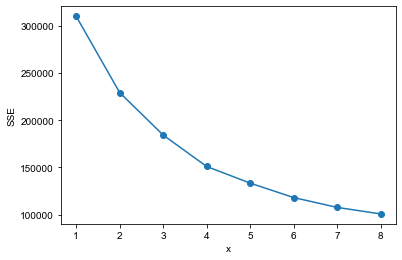

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

SSE=[]
for k in range(1,9):
    pred=KMeans(n_clusters=k,init='k-means++').fit(data_zscore)
    SSE.append(pred.inertia_)
x=range(1,9)
plt.plot(x,SSE,'o-')
plt.ylabel('SSE')
plt.xlabel('x')
##//用手肘法看不出最佳K值

In [20]:
from sklearn.cluster import KMeans

k = 5 #聚类为5类
     
# 调用KMeans方法，进行分析。n_job为并行数，设定为CPU数目较好
kmeans_model = KMeans(n_clusters=k, init='k-means++', random_state=0, n_jobs=-1)
# 训练模型
kmeans_model.fit(data_zscore) 

# 查看聚类中心以及聚类数目
r1=pd.Series(kmeans_model.labels_).value_counts()
r2=pd.DataFrame(kmeans_model.cluster_centers_)
r=pd.concat([r2, r1], axis=1)

r.columns=list(data_zscore.columns)+['类别数目']

print(r)

         ZL        ZR        ZF        ZM        ZC   类别数目
0  0.481118 -0.799457  2.484936  2.424947  0.289785   5319
1  1.153917 -0.373248 -0.091378 -0.100203 -0.144181  15941
2  0.133573 -0.031704 -0.161022 -0.150034  2.450926   3423
3 -0.314232  1.680383 -0.573959 -0.537437 -0.153458  12261
4 -0.699703 -0.409682 -0.166363 -0.167367 -0.226518  25100


In [21]:
r_num = pd.DataFrame(r)

In [22]:
r_num['客户群'] = ['客户群1','客户群2','客户群3','客户群4', '客户群5']

In [23]:
r_num

,ZL,ZR,ZF,ZM,ZC,类别数目,客户群
0,0.481118,-0.799457,2.484936,2.424947,0.289785,5319,客户群1
1,1.153917,-0.373248,-0.091378,-0.100203,-0.144181,15941,客户群2
2,0.133573,-0.031704,-0.161022,-0.150034,2.450926,3423,客户群3
3,-0.314232,1.680383,-0.573959,-0.537437,-0.153458,12261,客户群4
4,-0.699703,-0.409682,-0.166363,-0.167367,-0.226518,25100,客户群5


In [24]:
import matplotlib.pyplot as plt

# 设置中文字体和负号正常显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [31]:
# 重要属性，cluster_centers_,查看质心(中间点)
centerid = kmeans_model.cluster_centers_
centerid

array([[ 0.48111781, -0.79945701,  2.48493567,  2.4249467 ,  0.28978506],
       [ 1.15391745, -0.37324765, -0.09137788, -0.10020288, -0.14418062],
       [ 0.13357336, -0.03170445, -0.1610223 , -0.15003364,  2.45092612],
       [-0.31423163,  1.68038256, -0.5739591 , -0.53743738, -0.15345809],
       [-0.69970268, -0.40968239, -0.1663633 , -0.16736672, -0.22651811]])

In [28]:
data_LRFMC.head()

,L,R,F,M,C
0,90,1,210,580717,0.961639
1,86,7,140,293678,1.252314
2,87,11,135,283712,1.254676
3,68,97,23,281336,1.090870
4,60,5,152,309928,0.970658


In [29]:
data_LRFMC.columns

Index(['L', 'R', 'F', 'M', 'C'], dtype='object')

In [32]:
#  各客户群体的中心点
clf = pd.DataFrame(data=centerid, 
                   index=['客户群1','客户群2','客户群3','客户群4', '客户群5'],
                   columns=data_LRFMC.columns).round(2)
clf

,L,R,F,M,C
客户群1,0.48,-0.80,2.48,2.42,0.29
客户群2,1.15,-0.37,-0.09,-0.10,-0.14
客户群3,0.13,-0.03,-0.16,-0.15,2.45
客户群4,-0.31,1.68,-0.57,-0.54,-0.15
客户群5,-0.70,-0.41,-0.17,-0.17,-0.23


In [26]:
# 查看电脑有哪些字体，方便绘图的时候，可以显示中文
from matplotlib.font_manager import FontManager
fm = FontManager()
mat_fonts = set(f.name for f in fm.ttflist)
print(mat_fonts)

{'Noto Sans Mongolian', 'Al Nile', 'Zapfino', 'Noto Sans Kharoshthi', 'AppleMyungjo', 'PT Mono', 'Noto Sans Tai Viet', 'Mishafi', 'Marion', 'IBM 3270', '.Aqua Kana', 'Noto Sans Tai Tham', 'Symbol Neu for Powerline', '.Keyboard', 'Zapf Dingbats', 'Noto Sans Samaritan', 'Verdana', 'Courier New', 'Inconsolata-g for Powerline', 'Go Mono for Powerline', 'Papyrus', 'Nadeem', 'Roboto Mono Light for Powerline', 'Futura', 'SignPainter', 'Helvetica Neue', 'DejaVu Sans Mono for Powerline', '.Arabic UI Display', 'Noto Sans Kayah Li', 'Shree Devanagari 714', 'AppleGothic', 'Source Code Pro for Powerline', 'Noto Sans Lycian', 'STIXSizeThreeSym', 'Bodoni 72 Oldstyle', 'Liberation Mono for Powerline', 'Helvetica', 'Hiragino Mincho ProN', 'Apple SD Gothic Neo', 'Meslo LG S DZ for Powerline', 'Noto Sans Sundanese', 'Sana', 'Palatino', 'Fira Mono for Powerline', '.SF NS Rounded', 'cmtt10', 'Waseem', 'Noto Sans Yi', 'Lao MN', 'Noto Sans Inscriptional Pahlavi', 'Roboto Mono Medium for Powerline', '.SF NS T

range(0, 5)


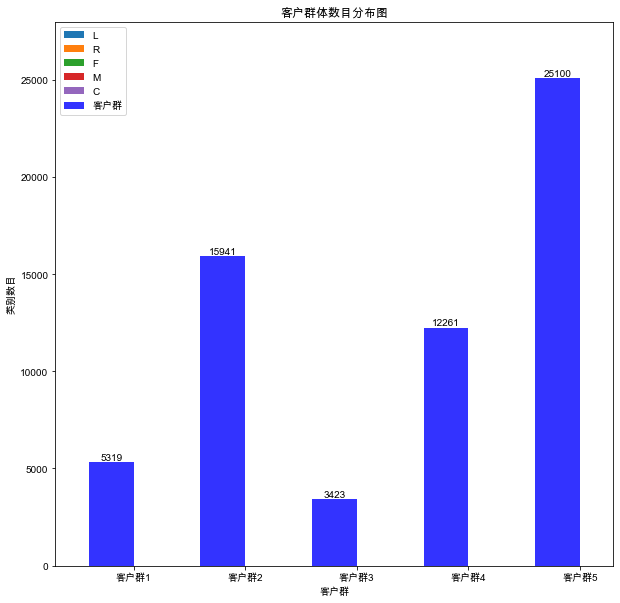

In [33]:
custom = r_num['客户群'].values.tolist()
label_num = r_num['类别数目'].values.tolist()

x = range(len(label_num))
print(x)
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""

clf.plot.bar(figsize=(10,10))
plt.xticks(rotation=0)

rects = plt.bar(range(5), height=label_num, width=0.4, alpha=0.8, color='blue', label="客户群")

plt.ylim(0, 28000)     # y轴取值范围
plt.ylabel("类别数目")
"""
设置x轴刻度显示值
参数一：中点坐标
参数二：显示值
"""
plt.xticks([index + 0.2 for index in x], custom)
plt.xlabel("客户群")
plt.title("客户群体数目分布图")
plt.legend()     # 设置题注
# 编辑文本
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")

plt.show()

In [35]:
data_LRFMC['MEMBER_NO'] = data['MEMBER_NO']
data_LRFMC['labels'] = kmeans_model.labels_
data_LRFMC[['MEMBER_NO','L','R','F','M','C','labels']].tail()

,MEMBER_NO,L,R,F,M,C,labels
62039,11163,108,89,2,368,0.710,1
62040,30765,65,121,2,368,0.670,1
62041,10380,45,39,2,1062,0.225,4
62042,16372,15,464,2,904,0.250,3
62043,22761,36,282,2,760,0.280,3


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '客户群1'),
  Text(1, 0, '客户群2'),
  Text(2, 0, '客户群3'),
  Text(3, 0, '客户群4'),
  Text(4, 0, '客户群5')])

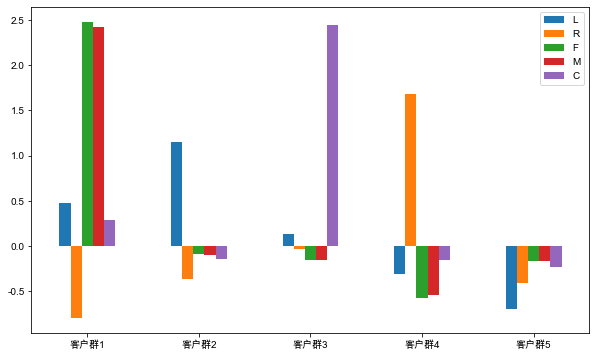

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial Unicode MS'

clf.plot.bar(figsize=(10,6))
plt.xticks(rotation=0)

# 5.客户价值分析


L：Long，会员入会时间距观测窗口结束的时间（月份），入会时间。
R：Recency 客户最近一次乘坐公司飞机距离观测窗口结束的时间（月份）。
F：Frequency 客户在观测窗口内乘坐公司飞机的次数。
M：Milepost，客户在观测窗口内累计的飞行里程碑。
C：Count，客户在观测窗口内乘坐仓位所对应的折扣系数的平均值。

针对聚类结果进行特征分析，其中

              优势	       劣势	              数目
    客户群1	L、F、M、C	    R      	            5319
    客户群2	L	          R、F、M、C	        15941
    客户群3	L、C	         R、M、F  	        3423
    客户群4	R	 	      L、F、M、C           12261
    客户群5	              L、R、F、M、C	 	    25100



### 分析：

客户群1，累计总飞行公里数较大，飞行次数较多，最近乘坐过飞机，属于重要保持客户。

客户群2，数量较多，加入会员时间长，但是最近乘坐频率变小，属于重要挽留客户。

客户群3，数量最少，所乘航班折扣率较高（一般所乘航班的等级较高），属于重要发展客户。

客户群4，数量较多，所乘航班折扣率较低，加入会员时间短，这类客户一般在打折时才会乘坐航班，属于一般客户。

客户群5，乘坐次数很少，累计总飞行公里数较少，很久没有乘坐飞机，属于低价值客户。
 



### 客户价值排名：

    客户群	排名	排名含义

    客户群1	1	重要保持客户

    客户群2	2	重要发展客户
    
    客户群2	3	重要挽留客户

    客户群4	4	一般客户

    客户群5	5	低价值客户


其中重要发展客户、重要保持客户、重要挽留客户分别对应客户生命周期管理的发展期、稳定期、衰退期。
 
# 6.结论：

## 根据对每个客户群进行特征分析，采取针对性营销：

### 1. 会员升级与保级--客户群4（数量较大）
### 2. 首次兑换--客户群2
### 3.交叉销售--客户群5